In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#-------------------Inputs-------------------------------------------------------------
script = "Longitudinal Analysis_4 Paddler.ipynb"
input_file = "Station Information.csv"
outerHull_file = "Outer Hull.csv" # Will be used for hydrostatic force and waterline calculation
DLF = 1.25 # Dead Load Factor
LLF = 1.3 # Live Load Factor
pad_male = 81.64 # Weight of male padder (kg)
pad_female = 68.03 # Weight of female paddler (kg)
water_den = 1000 # Density of water = 1000 kg/m^3
#--------------------------------------------------------------------------------------
pad1_po = 1489 # Position of first paddler with respect to left end of canoe (mm)
pad2_po = 2256 # Position of second paddler with respect to left end of canoe (mm)
pad3_po = 3495 # Position of third paddler with respect to left end of canoe (mm)
pad4_po = 4248 # Position of fourth paddler with respect to left end of canoe (mm)
pad_first = pad_male # Choose between pad_male and pad_female
pad_second = pad_female # Choose between pad_male and pad_female
pad_third = pad_female # Choose between pad_male and pad_female
pad_fourth = pad_male # Choose between pad_male and pad_female
pad1 = pad_first*LLF
pad2 = pad_second*LLF
pad3 = pad_third*LLF
pad4 = pad_fourth*LLF
#--------------------------------------------------------------------------------------

script_dir = os.path.abspath('') # absolute file path in Jupyter
file_path = os.path.join(script_dir, input_file) # file path for the text file input
canoe_info = pd.read_csv(file_path, header=None)
statVol = canoe_info[1][1:]
statMass = canoe_info[2]

file_path = os.path.join(script_dir, outerHull_file) # file path for the text file input
out_coor = pd.read_csv(file_path, header=None)
x_out = out_coor[0]
y_out = out_coor[1]
z_out = out_coor[2]

# Convert Series to List
stat_Mass = []
for i in range(1,len(statMass),1):
    stat_Mass.append(float(statMass[i]))

stat_Vol = []
for i in range(1,len(statVol),1):
    stat_Vol.append(float(statVol[i]))

canoe_volume = np.sum(stat_Vol) # m^3
canoe_weight = np.sum(stat_Mass) #[kg]
total_weight = canoe_weight*DLF + pad1 + pad2 + pad3 + pad4 #[kg]

station_no = x_out.nunique() # number of stations
station = x_out.unique() # location of each station

In [14]:
# Outer Hull Volume
vol_out = []
for k in range(1,station_no-2,1):
    X1_value = station[k]
    X2_value = station[k+1]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []

    for i in range(0,len(x_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])

        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    
    volume = 0
    if len(Y1)/2 == 0:
        n = int(len(Y1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
    else:
        n = int((len(Y1)-1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        # triangle piece at the bottom
        area1 = abs(Y1[n-1])*abs(Z1[n-1])/2*2
        area2 = abs(Y2[n-1])*abs(Z2[n-1])/2*2
        volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        vol_out.append(volume)

outer_volume = np.sum(vol_out)/10**9 #[m^3]

In [15]:
# Acquire the waterline from grasshopper
grasshopper = 164 # [mm]
canoe_depth = max(abs(z_out)) 
waterline = canoe_depth - grasshopper # distance from the water surface to the bottom of canoe [mm]
increment = 1 # push down waterline by [] mm
water_weight = outer_volume*water_den # Assume canoe is fully submerged in water

#while water_weight - total_weight > 10:
vol_out = []
for k in range(1,station_no-2,1):
    X1_value = station[k]
    X2_value = station[k+1]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []

    for i in range(0,len(x_out),1):
        if canoe_depth - abs(z_out[i]) <= waterline:
            if x_out[i] == X1_value:
                Y1.append(y_out[i])
                Z1.append(z_out[i])

            elif x_out[i] == X2_value:
                Y2.append(y_out[i])
                Z2.append(z_out[i])
    
    Y1.insert(0, Y1[0])
    Y1.append(Y1[len(Y1)-1])
    Z1.insert(0, waterline - canoe_depth)
    Z1.append(waterline - canoe_depth)
    
    Y2.insert(0, Y2[0])
    Y2.append(Y2[len(Y2)-1])
    Z2.insert(0, waterline - canoe_depth)
    Z2.append(waterline - canoe_depth)
    
    
    volume = 0
    if len(Y1)/2 == 0:
        n = int(len(Y1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
    else:
        n = int((len(Y1)-1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        # triangle piece at the bottom
        area1 = abs(Y1[n-1])*abs(Z1[n-1])/2*2
        area2 = abs(Y2[n-1])*abs(Z2[n-1])/2*2
        volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        vol_out.append(volume)


# Volumes of decks
X1_value = station[0]
X2_value = station[0+1]
Y1 = []
Y2 = []
Z1 = []
Z2 = []

for i in range(0,len(x_out),1):
    if x_out[i] == X1_value:
        Y1.append(y_out[i])
        Z1.append(z_out[i])

    if canoe_depth - abs(z_out[i]) <= waterline:
        if x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])

l = abs(max(Y2)-min(Y2))
w = abs(max(Z2)-min(Z2))
h = abs(X2_value - X1_value)
volume = l*w*h/3
vol_out.insert(0, volume)

X1_value = station[len(station)-1]
X2_value = station[len(station)-2]
Y1 = []
Y2 = []
Z1 = []
Z2 = []

for i in range(0,len(x_out),1):
    if x_out[i] == X1_value:
        Y1.append(y_out[i])
        Z1.append(z_out[i])
        
    if canoe_depth - abs(z_out[i]) <= waterline:
        if x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])

l = abs(max(Y2)-min(Y2))
w = abs(max(Z2)-min(Z2))
h = abs(X2_value - X1_value)
volume = l*w*h/3
vol_out.append(volume)


water_volume = np.sum(vol_out)/10**9 #[m^3]
water_weight = water_volume*water_den
    
    #waterline = waterline - increment

print('The depth of water is ', waterline, ' mm.')
print('The waterline is at', canoe_depth-waterline, 'mm.')
print('The weight of water is ', water_weight, 'kg.')
print('The total weight is ', total_weight, 'kg.')

The depth of water is  178.5  mm.
The waterline is at 164.0 mm.
The weight of water is  435.3728318105509 kg.
The total weight is  576.1540515930722 kg.


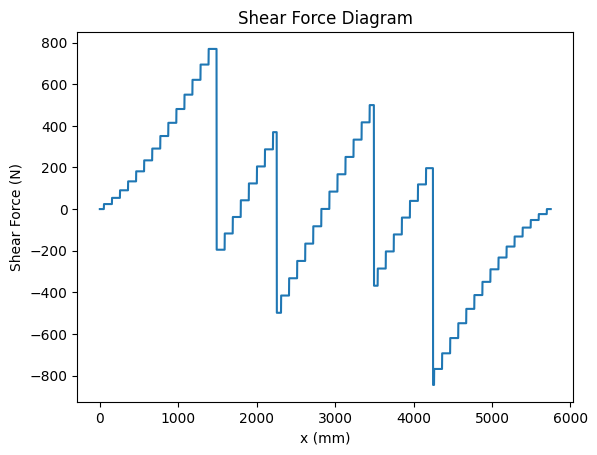

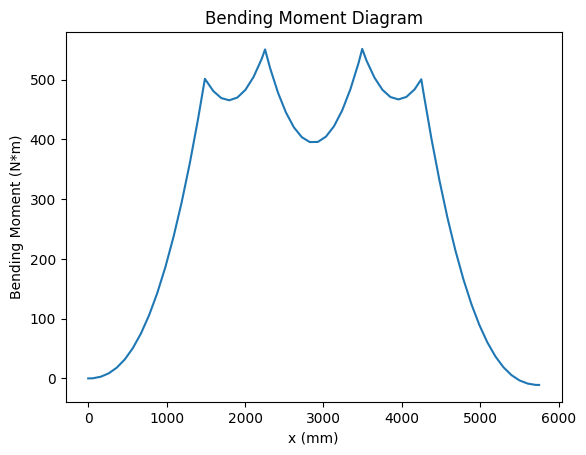

Maximum positive shear is  769.2652338080474 N.
Maximum negative shear is  -844.5996490754951 N.
Maximum positive moment is  551.4554348385294 Nm.
Maximum negative moment is  -10.905926562435916 Nm.
Moment at the end is  -10.905926562435825 Nm.


In [16]:
difference = water_weight - total_weight
vol_mass = []

for i in range(0,len(vol_out),1):
    mass = (vol_out[i]/10**9)*water_den - difference/len(vol_out)
    vol_mass.append(mass)
    
# Plot SFD and BMD
pad_weight = [pad1, pad2, pad3, pad4]

length = max(x_out)
pad_po = [pad1_po, pad2_po, pad3_po, pad4_po]

stat_x = []
for i in range(0,len(station)-1,1):
    stat_x.append((station[i]+station[i+1])/2)

g = 9.81
x = []
shear = []
for i in range(0,int(length),1):
    x.append(i)
    shear_force = 0
    for j in range(0,len(stat_x),1):
        if i >= stat_x[j]:
            shear_force  = shear_force + vol_mass[j]*g +(-1)*stat_Mass[j]*g*DLF
        else:
            shear_force = shear_force
    for k in range(0,len(pad_po),1):
        if i >= pad_po[k]:
            shear_force = shear_force - pad_weight[k]*g
        else:
            shear_force = shear_force
    shear.append(shear_force)

plt.plot(x,shear)
plt.title('Shear Force Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Shear Force (N)')
plt.show()

moment = []
moment.append(0)
bending_moment = 0
for i in range(1,len(x),1):
    bending_moment = bending_moment + (x[i]-x[i-1])*shear[i]/1000
    moment.append(bending_moment)

plt.plot(x,moment)
plt.title('Bending Moment Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Bending Moment (N*m)')
plt.show()

shear_max_index = shear.index(max(shear))
#x(shear_max_index)

print('Maximum positive shear is ', max(shear), 'N.')
print('Maximum negative shear is ', min(shear), 'N.')
print('Maximum positive moment is ', max(moment), 'Nm.')
print('Maximum negative moment is ', min(moment), 'Nm.')
print('Moment at the end is ', moment[len(moment)-1],'Nm.')

In [17]:
# export the values to csv file
titles = ['Positive Shear [N]', 'Negative Shear [N]', 'Positive Bending Moment [Nm]', 'Negative Bending Moment [Nm]', 'Moment at the end [Nm]']
values = [max(shear), min(shear), max(moment), min(moment), moment[len(moment)-1]]
station_no = []
max_width = []
max_depth = []
station_t = [] # Station thickness

for value in [max(shear), min(shear)]:
    shear_index = shear.index(value)
    xshear = x[shear_index]
    for i in range(0,len(station)-1,1):
        if (xshear >= station[i] and xshear < station[i+1]):
            station_index = i+1

    X1_value = station[station_index-1]
    X2_value = station[station_index]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []        
    for i in range(0,len(y_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    width = (max(Y1)-min(Y1)+max(Y2)-min(Y2))/2
    depth = (abs(min(Z1))+abs(min(Z2)))/2
    max_width.append(width)
    max_depth.append(depth)
    station_no.append(station_index)
    station_t.append(abs(X2_value - X1_value))

for value in [max(moment), min(moment)]:
    moment_index = moment.index(value)
    xmoment = x[moment_index]
    for i in range(0,len(station)-1,1):
        if (xmoment >= station[i] and xmoment < station[i+1]):
            station_index = i+1

    X1_value = station[station_index-1]
    X2_value = station[station_index]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []        
    for i in range(0,len(y_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    width = (max(Y1)-min(Y1)+max(Y2)-min(Y2))/2
    depth = (abs(min(Z1))+abs(min(Z2)))/2
    max_width.append(width)
    max_depth.append(depth)
    station_no.append(station_index)
    station_t.append(abs(X2_value - X1_value))
    
station_no.append(len(station)-1)  
max_width.append('')
max_depth.append('')
station_t.append('')

df1 = pd.DataFrame(data={'': titles, 'Value': values, 'Station No': station_no, 'Max Width [mm]': max_width, 'Max Depth [mm]': max_depth, 'Station Thickness [mm]': station_t})

csv_file = 'Shear_and_Moment_4 Paddlers.csv'
script_dir = os.path.abspath('')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)



In [18]:
# Make a CSV file for buoyancy and gravity
# vol_mass (Array of force_buoyancy by station)
# stat_mass (Array of force_gravity by station)
df1 = pd.DataFrame(data={'Station No.': range(1, len(vol_mass) + 1, 1), 'Buoyancy Force [N]': [i * g for i in vol_mass], 'Applied Force [N]': [i * g for i in stat_Mass] })

csv_file = 'Station_Loads_4 Paddlers.csv'
script_dir = os.path.abspath('')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)
print("Complete !")

Complete !
